In [1]:
import math
import pandas as pd
from pandas import DataFrame
from scipy import special
from IPython.display import display
from matplotlib.ticker import FuncFormatter

from fuzzing_campaign_analysis import *
from fuzzying_sim import *

%matplotlib inline

In [25]:

        
# Test

print(len(expected_find_sim(1000000, 16055, 2.19, 2)))

91


### New Fitting

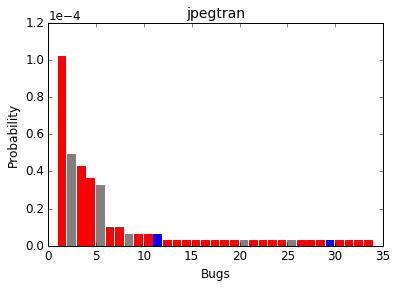

In [30]:
target = "jpegtran"

corrData, fuzz_info, fuzz_bug_accu, seed_info = analyze_one_campaign(target, chart="bar", alpha_cached=True)

# print(fuzz_info)

xpdf
ffmpeg
mupdf
autotrace
convert
jpegtran
xpdf
Correlation between virility and exploitability
r = -0.348132179556
p = 0.059398505398
ffmpeg
Correlation between virility and exploitability
r = -0.163326279569
p = 0.247304693447
mupdf
Correlation between virility and exploitability
r = -0.208927426638
p = 0.350763514743
autotrace
Correlation between virility and exploitability
r = 0.0227036760178
p = 0.947172862159
convert
Correlation between virility and exploitability
r = -0.0548270179133
p = 0.68270971194
jpegtran
Correlation between virility and exploitability
r = 0.0330031655007
p = 0.867590854908


,EXPLOITABLE,NOT_EXPLOITABLE,PROBABLY_EXPLOITABLE,PROBABLY_NOT_EXPLOITABLE,UNKNOWN,alpha,bug_count,crash_count,max_crash,run_count
autotrace,0.39,0.00,0.04,0.04,0.52,3.25,23,2548,593,29729
convert,0.33,0.00,0.03,0.07,0.57,2.38,134,32176,3197,79672
ffmpeg,0.08,0.00,0.17,0.29,0.46,2.2,96,3872,863,16055
jpegtran,0.79,0.00,0.06,0.00,0.15,3.53,33,116,31,303898
mupdf,0.24,0.00,0.00,0.64,0.12,2.88,25,201,61,9900
xpdf,0.27,0.00,0.32,0.22,0.19,2.38,37,185,73,4303


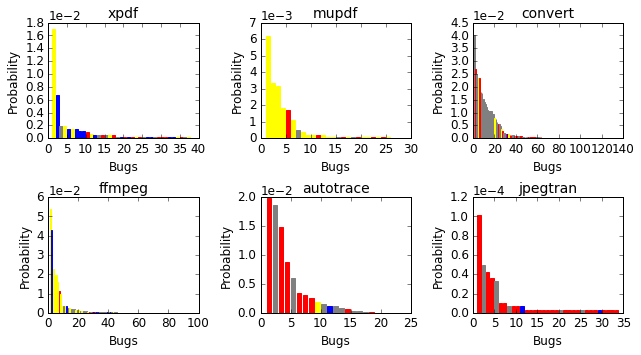

In [2]:
progs = ["xpdf", "mupdf", "convert", "ffmpeg", "autotrace", "jpegtran"]

prog_fuzz_info = {}

fuzz_info_list = ["alpha", "run_count", "max_crash", "crash_count", "bug_count", "k"]

for prog in progs:
    prog_fuzz_info[prog] = {}

prog_fuzz_bug_accu = {}

prog_seed_info = {}

draw_freq_dists(progs, prog_fuzz_info, prog_fuzz_bug_accu, prog_seed_info)

df = DataFrame.from_dict(prog_fuzz_info).T

display(df)

In [29]:
# These are the same
assert special.zeta(1.26, 1) - (special.zetac(1.26) + 1) < 0.0000001


alpha = 3.53

def enum_discrete_powerlaw(alpha):

    denom = special.zeta(alpha, 1)

    values = []
    
    n = 1001
    
    for i in range(1, n):
        value = math.pow(i, -alpha) / denom
        values.append(value)
        # print(value)
        
    # This grows to 1 as we increase n.
    print("Sum: " + str(1 - sum(values)))
    
    return values
    
values = enum_discrete_powerlaw(alpha)
    

Sum: 9.0323023505e-09


In [16]:
for prog in progs:
    k = getK(prog_fuzz_info[prog]["alpha"], prog_fuzz_info[prog]["max_crash"] / prog_fuzz_info[prog]["run_count"])
    prog_fuzz_info[prog]["k"] = k
    print(prog + " k = " + str(k))

xpdf_3.02-2 k = 5
mupdf k = 5
convert k = 3
ffmpeg k = 3
autotrace k = 4
jpegtran k = 20


In [32]:
# We need to manually select the upper and lower bound.
# We should see the diff changes from positive to negative.  
def estN(fuzz_info, low, up, exp_method = "stochastic"):

    t = fuzz_info["run_count"]
    alpha = fuzz_info["alpha"]
    d = fuzz_info["bug_count"]

    minDiff = None 
    opN = None
    
    seePos = False
    seeNeg = False

    for n in range(low, up, 1):
        
        if exp_method == "stochastic":
            _d = expected_find(n, t, alpha)
        elif exp_method == "sim":
            _bugs = []
            for i in range(0, 10):
                bugs, bugs_accu, seq = expected_find_sim(n, t, alpha)
                _bugs.append(len(bugs))
            _d = np.mean(_bugs)
        # print(_d)
        diff = d - _d
        
        if diff > 0:
            seePos = True
        if diff < 0:
            seeNeg = True

        diff = abs(diff)
        
        if minDiff is None or diff < minDiff:
            minDiff = diff
            opN = n
            
        if seePos and seeNeg:
            # Alreay find the optimal point.
            break
        
        #if n % 10 == 0:
        #    print(str(n) + ", " + str(d - _d))

    assert seePos and seeNeg
    
    print("opN = " + str(opN))
    print("minDiff = " + str(minDiff))
    return opN


# We manually cache the results, because obtaining them takes long time.
prog_fuzz_info["xpdf"]["n_sim"] = 167
prog_fuzz_info["mupdf"]["n_sim"] = 91
prog_fuzz_info["convert"]["n_sim"] = 652
prog_fuzz_info["ffmpeg"]["n_sim"] = 342
prog_fuzz_info["autotrace"]["n_sim"] = 26
prog_fuzz_info["jpegtran"]["n_sim"] = 55

for prog in progs:
    print(prog)
    n = estN(prog_fuzz_info[prog], prog_fuzz_info[prog]["bug_count"], 1000, exp_method="stochastic")
    prog_fuzz_info[prog]["n"] = n

xpdf
opN = 61
minDiff = 0
mupdf
opN = 32
minDiff = 0
convert
opN = 257
minDiff = 0
ffmpeg
opN = 226
minDiff = 0
autotrace
opN = 27
minDiff = 0
jpegtran
opN = 36
minDiff = 0


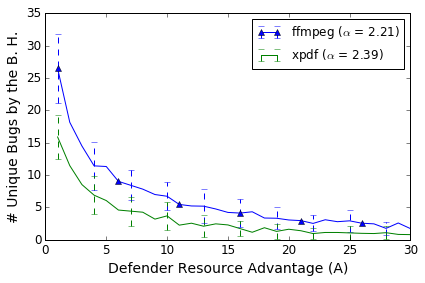

In [35]:
def drawBHUnique(prog1, prog2):
    BHUniqueSizes = []
    BHUniqueSizes2 = []
    repeat = 30
    
    CSizeBHUnique = [] 
    CSizeBHUnique2 = []
    CMax = 31
    
    alpha = prog_fuzz_info[prog1]["alpha"]
    n = prog_fuzz_info[prog1]["n_sim"]
    alpha2 = prog_fuzz_info[prog2]["alpha"]
    n2 = prog_fuzz_info[prog2]["n_sim"]
    
    for C in range(1, CMax):
        
        CSizeBHUnique.append([])   
        CSizeBHUnique2.append([])
        
        for i in range(0, repeat):
            bugs, bugs_accu, seqComp = expected_find_sim(n, 10000 * C, alpha)
            bugs, bugs_accu, seqBH = expected_find_sim(n, 10000, alpha)
            
            sizeBH = len(seqBH)
            sizeComp = len(seqComp)    
            sizeBHUnique = len(seqBH) - len(set(seqComp).intersection(seqBH))
            CSizeBHUnique[C - 1].append(sizeBHUnique)
            # print(str(sizeComp) + ", " + str(sizeBH) + ", " + str(sizeBHUnique)) 

            # Should be merged:
            bugs, bugs_accu, seqComp = expected_find_sim(n2, 10000 * C, alpha2)
            bugs, bugs_accu, seqBH = expected_find_sim(n2, 10000, alpha2)
            
            sizeBH = len(seqBH)
            sizeComp = len(seqComp)    
            sizeBHUnique = len(seqBH) - len(set(seqComp).intersection(seqBH))
            CSizeBHUnique2[C - 1].append(sizeBHUnique)

    stdList = []
    stdList2 = []
    for C in range(1, CMax):
        BHUniqueSizes.append(np.mean(CSizeBHUnique[C - 1]))
        stdList.append(np.std(CSizeBHUnique[C - 1]))
        BHUniqueSizes2.append(np.mean(CSizeBHUnique2[C - 1]))
        stdList2.append(np.std(CSizeBHUnique2[C - 1]))    

    fontSize = 14
    figWidth = 7
    figHeight = 5
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('Defender Resource Advantage (A)', fontsize=fontSize)
    ax.set_ylabel('# Unique Bugs by the B. H.', fontsize=fontSize)
    
    eb = plt.errorbar(np.arange(len(BHUniqueSizes)) + 1, BHUniqueSizes, yerr=stdList, errorevery=3, marker="^", markevery=5, label=prog1 + r" ($\alpha$ = " + str("{0:.2f}".format(alpha)) + ")")
    eb[-1][0].set_linestyle('--')
    
    eb = plt.errorbar(np.arange(len(BHUniqueSizes2)) + 1, BHUniqueSizes2, yerr=stdList2, errorevery=3, label=prog2 + r" ($\alpha$ = " + str("{0:.2f}".format(alpha2)) + ")")
    eb[-1][0].set_linestyle('--')
    


    ax.legend(loc=1)
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    
    fig.tight_layout()
    
    fig.savefig("../output/bhUnique.pdf")

drawBHUnique("ffmpeg", "xpdf")

In [5]:
bugs, bugs_accu, seqComp = expected_find_sim(100, 1000, 2.5)

print(seqComp)

[2.0, 3.0, 4.0, 6.0, 7.0, 23.0, 17.0, 5.0, 33.0, 20.0, 8.0, 24.0, 13.0, 9.0, 18.0, 11.0]


In [3]:
# We simulate 5 different discovery sequences of fuzzing the same program.
runSeqSim(1000, 15, prog_fuzz_info["ffmpeg"])

 & \textbf{19} & 3 & 2 & 9 & 4 & 5 & 12 & 14 & 6 & \textbf{84} & 10 & 7 & \textbf{85} & \textbf{95} & \textbf{24}

 & 2 & 3 & 7 & 4 & 5 & \textbf{17} & 10 & 13 & \textbf{40} & 8 & 6 & \textbf{49} & 12 & 11 & 9

 & 2 & 4 & 5 & \textbf{28} & 3 & 6 & 7 & \textbf{18} & 9 & 12 & 13 & 20 & 11 & 10 & \textbf{21}

 & 2 & 5 & 6 & 3 & 4 & 9 & \textbf{15} & 12 & \textbf{99} & 10 & 8 & \textbf{46} & 7 & \textbf{225} & 20

 & 3 & 2 & 4 & 7 & 8 & 5 & \textbf{27} & 10 & 11 & 6 & 9 & \textbf{23} & \textbf{82} & 14 & 12



xpdf
ffmpeg
mupdf
autotrace
convert
jpegtran


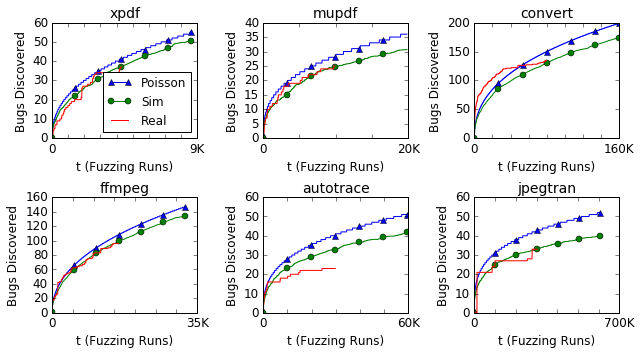

In [6]:

# Here, we see that by increasing n over a magnitude, the number of expected discovery
# only grows linearly.
# print(expected_find(1000, 1000, 1.8, 100))
# print(expected_find(10000, 1000, 1.8, 100))
# print(expected_find(100000, 1000, 1.8, 100))


def thousand_k(x, pos):
    'The two args are the value and tick position'
    
    if x == 0:
        return "0"
    
    # Need to manually specify this
    step = 1
    
    return '{0}K'.format(int(round(x / 1000 * step)))

formatter = FuncFormatter(thousand_k)




def drawExpectedFind(prog, alpha, n_list, step, runs, ax=None, draw_real=True):
    
    single_graph = False
    
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        single_graph = True
    
    ax.set_title(prog, fontsize=14)
    ax.set_xlabel('t (Fuzzing Runs)', fontsize=12)
    ax.set_ylabel('Bugs Discovered', fontsize=12)
    
    for n in n_list:
        
        expected_bugs = []
        
        for t in range(0, runs, step): 
            expected_bugs.append(expected_find(1000, t, alpha))
        
        label = "Poisson" if not single_graph else "n = " + str(n)
        marker = "^" if not single_graph else None
        markevery = int(runs / 6) if not single_graph else None
        ax.plot(np.arange(len(expected_bugs)) + 1, expected_bugs, label=label, marker=marker, markevery=markevery)
    
    
    if draw_real:
        
        _bugs_accu = [0] * runs
        repeat = 10
        for i in range(0, repeat):
            bugs, bugs_accu, seq= expected_find_sim(1000, runs, alpha)
            for i in range(0, len(bugs_accu)):
                _bugs_accu[i] += bugs_accu[i]
            
        bugs_accu_avg = np.array(_bugs_accu) / repeat
        ax.plot(np.arange(len(bugs_accu)) + 1, bugs_accu_avg, label="Sim", marker="o", markevery=int(runs / 6))
        
        ax.plot(np.arange(len(prog_fuzz_bug_accu[prog])) + 1, prog_fuzz_bug_accu[prog], label="Real")
    #expected_bugs = []
    #for t in range(100, 100000, 100): 
    #    expected_bugs.append(int(round(expected_find(222, t, 2, discovered))))
            
    #plt.plot(np.arange(len(expected_bugs)) + 1, expected_bugs, label="n=" + str(n) + ", alpha=2")
        
    ax.set_ylim([0, ax.get_ylim()[1]])
    
    if prog == "xpdf":
        ax.legend(loc=4)
    
    ax.get_xaxis().set_major_formatter(formatter)
    
    if not single_graph:
        xticks = ax.xaxis.get_major_ticks()
        for xtick in xticks:
            xtick.label1.set_visible(False)
        xticks[0].label1.set_visible(True)
        xticks[-1].label1.set_visible(True)
    
    if single_graph:
        fig.tight_layout()
        fig.savefig("../output/expectedBugs_single.pdf")


        
def draw_all_expected(n = None):
        
    numRow = 2
    numCol = 3

    fig, axes = plt.subplots(nrows=numRow, ncols=numCol,
                             sharex=False, sharey=False)

    fig.set_size_inches(numCol * 3, numRow * 2.5)


    for i in range(0, numCol):
        for j in range(0, numRow):
            if numRow > 1:
                ax = axes[j][i]
            else:
                ax = axes[i]

            target = progs[j * numCol + i]

            print(target)
            
            _n = prog_fuzz_info[target]["n"] if n == None else 1000
                

            drawExpectedFind(target, prog_fuzz_info[target]["alpha"], [_n], 1, prog_fuzz_info[target]["run_count"] * 2, ax=ax)

    fig.tight_layout()
    fig.savefig("../output/expectedBugs.pdf")

# draw_all_expected(n=1000)
draw_all_expected()

# drawExpectedFind("ffmpeg", prog_fuzz_info["ffmpeg"]["alpha"], [100, 300, 1000, 10000], 1000, 100000, draw_real=False)    

### Seed-Crash Graph

59
[780, 794, 786, 1050, 793, 1617, 1144, 784, 2067, 2776, 834, 792, 1998, 804, 1350, 2239, 2808, 808, 805, 817, 1529, 1163, 1776, 803, 1965, 1679, 791, 3240, 1727, 792, 1264, 1377, 1566, 1683, 2025, 2492, 819, 2372, 3027, 1521, 1858, 1541, 1006, 796, 789, 808, 789, 2541, 786, 1487, 790, 793, 791, 824, 794, 808, 816, 776, 1422]


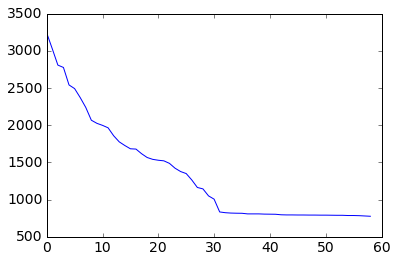

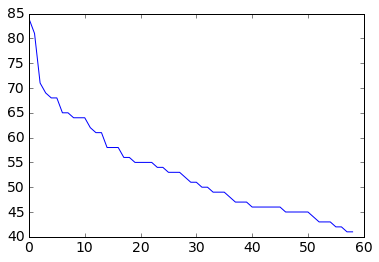

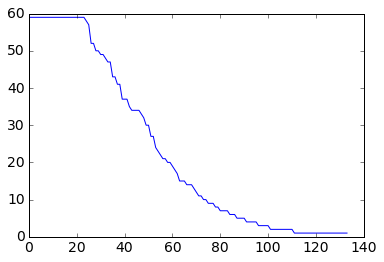

In [32]:
# Create the following dicts:
#   crash_seed
#   seed_crashes
#   seed_bugs

def analyze_seed_crash(prog):
    print(len(prog_seed_info[prog]["freq"]))
    
    freqs = list(prog_seed_info[prog]["freq"].values())
    
    print(freqs)
    
    plt.plot(sorted(freqs, reverse=True))
    
    fig = plt.figure()
    
    bug_counts = []
    
    bug_seeds = {}
    
    for seed in prog_seed_info[prog]["bugs"]:
        
        bug_count = len(prog_seed_info[prog]["bugs"][seed])
        bug_counts.append(bug_count)
        
        for bug in prog_seed_info[prog]["bugs"][seed]:
            if bug not in bug_seeds:
                bug_seeds[bug] = set()
            bug_seeds[bug].add(seed)
        
        # print(seed + ": " + str()
        
    plt.plot(sorted(bug_counts, reverse=True))
    
    bug_seed_counts = []
    
    for bug in bug_seeds:
        bug_seed_counts.append(len(bug_seeds[bug]))
    
    fig = plt.figure()
    
    plt.plot(sorted(bug_seed_counts, reverse=True))
    
        
    
analyze_seed_crash("convert")

### D(t) and E[D(t)] Curve

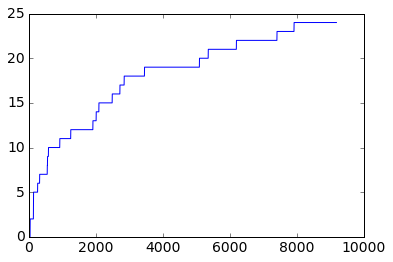

In [7]:
# Get a list. List[t] is the # unique bugs found at time t

# print(prog_fuzz_bug_accu["mupdf"])
    
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(len(prog_fuzz_bug_accu["mupdf"])) + 1, prog_fuzz_bug_accu["mupdf"])

### Discrete vs. Continuous

In [21]:
discrete = powerlaw.Power_Law(xmin=1, parameters=[2.5], discrete=True)
continuous = powerlaw.Power_Law(xmin=1, parameters=[2.5])


# We want to see all large values generated.
data = discrete.generate_random(10000)
for var in data:
    if var > 100:
        print(var)

print(discrete.generate_random(100))
print(np.round(continuous.generate_random(100)))

174.0
816.0
142.0
928.0
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   3.   1.   3.
   1.   1.   2.   1.   1.   1.   1.   1.   1.   1.   2.   1.   1.   1.   1.
   1.   3.   1.   2.   1.   1.   1.   1.   1.   3.   2.   1.   1.   4.   1.
   1.   1.  12.   2.   1.   3.   1.   2.   1.   2.   2.   1.   1.   1.   2.
   1.   1.  27.   1.   2.   4.   1.   1.   1.   1.   2.   6.   6.   1.   1.
   1.   1.   2.   1.   1.   2.   1.   1.   1.   1.   1.   1.   3.   1.   1.
   1.   1.   1.   1.   2.   1.   1.   2.   3.   1.]
[  1.   9.   1.   2.   2.  10.   1.   1.   1.  25.   5.   1.   1.   2.   2.
   2.   1.   1.   1.   1.   2.   2.   2.   2.   1.   4.   6.   1.   1.   1.
   3.   1.   5.  19.   1.   1.   2.   1.   2.   1.   4.   1.   2.   1.   2.
   1.   1.   2.   1.   1.   2.   1.   1.   1.   2.   1.   6.   2.   4.   1.
   1.   1.   2.   3.   1.   1.   2.   2.   1.   2.   1.  17.   3.   1.   1.
   1.   2.   1.   6.   1.   5.   2.   2.   1.   2.   1.   1.   1.   1.   3.
   2.   2.  